# Generarea digitală a muzicii

## Biblioteci

In [47]:
# Pentru operațiuni numerice pe vectori
import numpy as np
# Pentru afișarea grafică a semnalului generat
import matplotlib.pyplot as plt
# Pentru a reda semnalul audio
import sounddevice as sd

## Parametrii configurabili

In [48]:
# Rata de eșantionare
SAMPLING_RATE = 44100

# Amplitudinea semnalelor generate
AMPLITUDE = 10000

# Durata unei note întregi (poate modifica BPM-ul melodiei)
FULL_NOTE = 2

## Generator de tonuri

Melodiile pe care le voi compune sunt formate din mai multe tonuri, fiecare având o anumită notă muzicală asociată (o frecvență) și o durată (pătrime, doime, notă întreagă).

Am folosit o undă în formă de fierăstrău în loc de una sinusoidală, pentru că (subiectiv) sună mai bine.

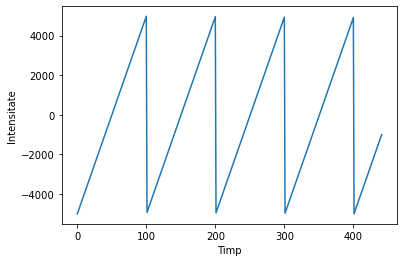

In [49]:
def sine(frequency, time):
    "Undă sinusoidală"
    return np.sin(frequency * time)

def sawtooth(frequency, time):
    "Undă în formă de dinți de fierăstrău"
    x = frequency * time
    return x - np.floor(x) - 1/2

# Dicționar care mapează numele notelor în frecvențe
frequencies = {}

def generate_tone(frequency, duration):
    "Generează un ton pur de frecvență dată, pentru durata cerută"

    n_samples = duration * SAMPLING_RATE
    time = np.linspace(0, duration, int(n_samples + 1))

    return AMPLITUDE * sawtooth(frequency, time)

def concat_tones(tones):
    "Concatenează mai multe tonuri pentru a obține o melodie mai lungă"
    return np.concatenate(tones)

def generate_song(notes):
    "Generează o melodie pornind de la o listă de note și durate"
    tones = [
        generate_tone(frequencies[name], FULL_NOTE * 1/d)
        for (name, d)
        in notes
    ]
    return concat_tones(tones)


plt.xlabel("Timp")
plt.ylabel("Intensitate")
plt.plot(generate_tone(440, 0.01))
plt.show()

## Note muzicale

În sistemul occidental de notație muzicală, avem 12 note distincte într-o scară.

La fiecare octavă, notele își dublează frecvența.

In [50]:
OCTAVE_RATIO = 2
SEMITONE_RATIO = OCTAVE_RATIO ** (1/12)
TONE_RATIO = SEMITONE_RATIO * SEMITONE_RATIO

În sistemul standard, nota La este mapată la frecvența 440 Hz, iar toate celelalte note se pot calcula în raport cu ea.

In [51]:
# Frecvența de bază
frequencies['A4'] = 440
# P reprezintă o pauză
frequencies['P'] = 0


def generate_octave(index):
    "Generează cele 12 note distincte, plecând de la Do pentru octava dată."
    index = str(index)
    frequencies['CS' + index] = frequencies['C' + index] * SEMITONE_RATIO
    frequencies['D' + index] = frequencies['C' + index] * TONE_RATIO
    frequencies['E' + index] = frequencies['D' + index] * TONE_RATIO
    frequencies['F' + index] = frequencies['E' + index] * SEMITONE_RATIO
    frequencies['FS' + index] = frequencies['F' + index] * SEMITONE_RATIO
    frequencies['G' + index] = frequencies['F' + index] * TONE_RATIO
    frequencies['GS' + index] = frequencies['G' + index] * SEMITONE_RATIO
    frequencies['A' + index] = frequencies['G' + index] * TONE_RATIO
    frequencies['B' + index] = frequencies['A' + index] * TONE_RATIO

# Urc câteva note ca să ajung la următorul Do
frequencies['C5'] = frequencies['A4'] * TONE_RATIO * SEMITONE_RATIO
frequencies['C6'] = frequencies['C5'] * OCTAVE_RATIO
frequencies['C4'] = frequencies['C5'] / OCTAVE_RATIO
frequencies['C3'] = frequencies['C4'] / OCTAVE_RATIO
frequencies['C2'] = frequencies['C3'] / OCTAVE_RATIO

# Generez octavele folosind notele Do
for i in range(2, 7):
    generate_octave(i)

## Redare audio

Biblioteca `sounddevice` permite redarea unui semnal audio (reținut ca un vector de eșantioane) prin sistemul audio al calculatorului.

In [52]:
sd.default.samplerate = SAMPLING_RATE

def play_song(song):
    wav_wave = np.array(song, dtype=np.int16)
    sd.play(wav_wave, blocking=True)
    sd.stop()

## Melodie clasică (Canon in D)

Pentru exercițiul 2 am pus câteva note din [Canon in D de Pachelbel](https://en.wikipedia.org/wiki/Pachelbel%27s_Canon). Notele sunt luate din [această transpunere](https://github.com/robsoncouto/arduino-songs/blob/master/cannonind/cannonind.ino).

In [56]:
notes = [
    ('FS4', 2), ('E4', 2),
    ('D4', 2), ('CS4', 2),
    ('B3', 2), ('A3', 2),
    ('B3', 2), ('CS4', 2),
    ('FS4', 2), ('E4', 2),
    ('D4', 2), ('CS4', 2),
    ('B3', 2), ('A3', 2),
]

canon_in_d = generate_song(notes)
play_song(canon_in_d)

# Partitură citită din fișier

## Format

Formatul ales este unul custom, fișierul trebuie să aibă următoarea structură:
```python
# Comentarii

A4 4 # note și durata lor (1 = notă întreagă, 2 = doime, 4 = pătrime)

P 1 # pauze și durata lor
```

## Citire și generare melodie pe baza partiturii

In [57]:
def load_song(fname):
    "Încarcă o partitură din fișierul dat ca parametru"

    # Parsez fișierul
    dtypes = [
        ('note', 'S3'),
        ('duration', int),
    ]
    data = np.genfromtxt(fname, dtype=dtypes, comments='#', delimiter=' ')

    # Transform notele din bytestring în string-uri
    notes = [
        (note.decode(), duration)
        for (note, duration)
        in data
    ]
    
    # Generez semnalul audio
    return generate_song(notes)

# Încarc o melodie de pe disc
song = load_song("partitura.txt")
play_song(song)